#### Brain Network Model fitting using RNN
     Zheng Wang
     
     Two type models: Linear Model and Wong-Wang-Deco Model
     
     

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

In [2]:
class Model_graph():
    
    ### default fit model parameteres:
    
    fit_param = ['g', 'gEE', 'gIE', 'gEI']#, 'sigma']
    
        
    def __init__(self, batch_size, step_size, Tr, truncated_backprop_length, num_states, num_states_noise, fit_conecctiongains):
        #self.args = kwargs
       

        
        self.fit_cg = fit_conecctiongains
        
        self.dt = step_size
        self.truncated_backprop_length = truncated_backprop_length
        self.Tr = Tr
        self.hidden_num = np.int(Tr/step_size)
        self.num_states = num_states
        self.num_states_noise = num_states_noise
        self.batch_size = batch_size
        self.num_inputs = 1+self.truncated_backprop_length*(1+self.num_states_noise*self.hidden_num)
        self.L_new = tf.placeholder(tf.float32, [self.batch_size, self.batch_size])
        self.batchX_placeholder = tf.placeholder(tf.float32, [self.batch_size, 1+self.truncated_backprop_length\
                                                    +2*self.truncated_backprop_length*self.hidden_num])
        self.batchY_placeholder = tf.placeholder(tf.float32, [self.batch_size, self.truncated_backprop_length])

        self.init_state = tf.placeholder(tf.float32, [self.batch_size, self.num_states])
        
    
    def build_graph(self):
        
        



        def fout(v, alpha):
            return tf.pow(v,1./alpha)
        def Ef(f):
            rho = 0.34
            return tf.constant(1., dtype=tf.float32)-tf.pow(tf.constant(1.-rho, dtype=tf.float32), tf.reciprocal(f))
        def h_tf(a, b, d, x):
            return( 0.00001+tf.abs(a*x-b))/(0.00001*d+tf.abs(1.0000 -tf.exp(-d*(a*x-b))))






        sigma = tf.constant(1.0, dtype=tf.float32) 
        epsilon = tf.constant(1.0, dtype=tf.float32)# + 0.3 *np.tanh(X[5:6]) # smooth_normalize(X[5:6], 0.5)
        tau_s = tf.constant(0.65, dtype=tf.float32)# + 0.2 *np.tanh(X[6:7])
        tau_f = tf.constant(0.41, dtype=tf.float32)# + 0.3 *np.tanh(X[7:8])

        I0=tf.constant(0.2, dtype=tf.float32)
        gamma = tf.constant(0.641/1000.0, dtype=tf.float32)
        gammaI = tf.constant(1/1000.0, dtype=tf.float32)

        Ie = tf.constant(0.0, dtype=tf.float32)

        aE=tf.constant(310, dtype=tf.float32)
        bE = tf.constant(125, dtype=tf.float32)
        dE =tf.constant(0.16, dtype=tf.float32)
        WE= tf.constant(1, dtype=tf.float32)
        tauE= tf.constant(100, dtype=tf.float32)

        aI=tf.constant(615, dtype=tf.float32)
        bI = tf.constant(177, dtype=tf.float32)
        dI =tf.constant(0.087, dtype=tf.float32)
        WI= tf.constant(0.7, dtype=tf.float32)
        tauI= tf.constant(10, dtype=tf.float32)

        rho=tf.constant(0.34, dtype=tf.float32)
        E0=tf.constant(0.34, dtype=tf.float32)
        k1 = tf.constant(7*0.34, dtype=tf.float32)
        k2 =tf.constant( 2, dtype=tf.float32)
        k3 = tf.constant(2*0.34-0.2, dtype=tf.float32)

        V = tf.constant(0.02, dtype=tf.float32)
        rho= tf.constant(0.34, dtype=tf.float32)
        tau_0= tf.constant(0.98, dtype=tf.float32) 
            #tau_s=0.8;
            #tau_f=0.4;
        alpha =tf.constant(0.32, dtype=tf.float32)

        dt=tf.constant(step_size, dtype=tf.float32)

        E_fr= tf.constant(np.zeros((batch_size,1)), dtype=tf.float32)

        #gi0 = 1.* np.zeros((batch_size,1))
        Ws0 = np.zeros((batch_size,batch_size))+0.05
        g0 = 80.

        W1 = tf.constant(0.02, dtype=tf.float32)#tf.Variable(0.2, dtype=tf.float32)
        gEE =tf.Variable(.5, dtype=tf.float32)
        G = tf.Variable(g0, dtype=tf.float32)
        #Gi = tf.Variable(gi0, dtype=tf.float32)
        Ws = tf.Variable(Ws0, dtype=tf.float32)
        gEI = tf.Variable(0.15, dtype=tf.float32)

        gIE = tf.Variable(0.1, dtype=tf.float32)   
        #c_gEE = tf.Variable(0.5, dtype=tf.float32) 
        c_a = tf.Variable(.5, dtype=tf.float32)   
        c_b = tf.Variable(20, dtype=tf.float32)
        c_c =  tf.Variable(10, dtype=tf.float32)


        # Unpack columns

        inputs_series = tf.unstack(self.batchX_placeholder, axis=1)
        labels_series = tf.unstack(self.batchY_placeholder, axis=1)

        W_n= 1+tf.tanh((Ws+tf.transpose(Ws))/2.0)
        W_n = W_n * self.L_new

        W_s =W_n/tf.norm(W_n)
        L= -tf.diag(tf.reduce_sum(W_s, axis=1)) + W_s

        # Forward pass
        current_state = self.init_state
        #current_state = _current_state
        states_series = []
        inhi_series = []
        E_series = []
        I_series = []
        logits_series = []
        noise2 = inputs_series[-truncated_backprop_length-1:-1]
        noise_c = inputs_series[-1]


        for j, label_tmp in enumerate(labels_series):
            #current_input = tf.reshape(current_input, [batch_size, 1])
            #input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns

            current_state_series = tf.unstack(current_state, axis= 1)

            E=current_state[:,0:1]
            I=current_state[:,1:2]
            x=current_state[:,2:3]
            f=current_state[:,3:4]
            v=current_state[:,4:5]
            q=current_state[:,5:6]

            G_p = 0.001+tf.nn.relu(G)
            #G_p = 5000./0.641/0.459 +tf.nn.relu(G)
            gIE_p = 0.001+ tf.nn.relu(gIE) #smooth_normalize_ct(Ji, tf.constant(1.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))

            gEI_p =0.001+tf.nn.relu(gEI)
            gEE_p =0.001+ tf.nn.relu(gEE)
            #c_gEE_p =0.001+ tf.nn.relu(c_gEE)
            c_a_p =0.001+ tf.nn.relu(c_a)
            c_b_p =0.001+ tf.nn.relu(c_b)
            c_c_p =0.001+ tf.nn.relu(c_c)


            W1_p = .01 + tf.nn.relu(W1)
            
            vars_ls =[G_p, gEE_p, gIE_p, gEI_p, W1_p]
            #W2_p = 0.01 + tf.nn.relu(W2)
            #W = (Gi_p*L_new)/tf.norm(Gi_p*L_new)
            #L = -tf.diag(tf.reduce_sum(W, axis=1)) + W
            for i in range(self.hidden_num):
                noise = tf.reshape(inputs_series[j*self.hidden_num+i],[self.batch_size, 1] )
                noise1 = tf.reshape(inputs_series[self.truncated_backprop_length*self.hidden_num\
                                                  +j*self.hidden_num+i],[self.batch_size, 1] )
                IE = tf.nn.relu(WE*I0 + gEE_p*E + G_p*tf.matmul(L, E) -gIE_p*(I) + Ie)
                II = tf.nn.relu(WI*I0 + gEI_p*E - I)

                #IE = 125/310.0 -0.026 +0.006*tf.tanh(IE/100. - 125/310.0 + 0.026) 
                #(3.0631+0.4869*tf.tanh(h_tf(aE, bE, dE, IE)-3.0631)) 
                E_new =E  -dt*(E)/tauE \
                            + dt*(1.0 -E)*gamma*h_tf(aE, bE, dE, IE) \
                            +W1*tf.sqrt(dt)*noise
                I_new =I - dt*(I)/tauI \
                           + dt*gammaI*h_tf(aI, bI, dI, II) +W1*tf.sqrt(dt)*noise1


                dx = x+dt*(epsilon*E/sigma-1.0/tau_s*x  -1.0/tau_f*(f-1.0))
                f_tmp= f+dt*x 
                dv= v+dt*(f/tau_0 -fout(v, alpha)/tau_0) 
                dq=q+ dt*(tf.multiply(f,Ef(f))/rho/tau_0-tf.multiply(tf.divide(q,v) ,fout(v, alpha)) /tau_0)
                v= 1.0+ tf.tanh(dv-1.0)#smooth_normalize_ct(dv, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
                q=  1.0+ tf.tanh(dq-1.0)#smooth_normalize_ct(dq, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
                f= 1.0+ tf.tanh(f_tmp-1.0) #smooth_normalize_ct(f_tmp, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
                x= tf.tanh(dx)
                E= tf.tanh(0.00001+tf.nn.relu(E_new)) #smooth_normalize_ct(E_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
                I= tf.tanh(0.00001+tf.nn.relu(I_new)) #smooth_normalize_ct(I_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
                E_series.append(E)
                I_series.append(I)
                #E_fr.append() = sigmoid_tf(aE, bE, dE, IE)
            next_state = tf.concat([E, I, x, f, v, q],1)  # Broadcasted addition
            #IE = WE*I0 + Wplus_p*Jnmda_p*E + G_p*Jnmda_p*tf.matmul(W, E) -tf.multiply(Ji_p,I) + Ie
            #E_fr = h_tf(aE, bE, dE, IE)
            states_series.append(next_state)
            #inhi_series.append(E_fr)
            current_state = next_state 
        #current_state = states_series[0]
        print(states_series[0].shape)
        print(inputs_series[0].shape)
        print(len(inputs_series))
        #logits_series = [tf.reshape(tf.matmul(W2, tf.reshape(tf.tanh(state), [batch_size*state_size, 1])) + b2, [batch_size,]) for state in states_series]#Broadcasted addition

        logits_series = [100.0/E0*V*(k1*(tf.constant(1., dtype=tf.float32)-state[:, 5])\
                         +k2*(tf.constant(1., dtype=tf.float32)-tf.divide(state[:, 5],state[:, 4]))\
                         +k3*(tf.constant(1., dtype=tf.float32)-state[:, 4]))\
                         +0.02*noise   for state, noise in zip(states_series, noise2)]
        print(logits_series[0].shape)
        print(labels_series[0].shape)

        predictions_series = logits_series

        labels_series_tf = tf.stack(labels_series,axis=1)
        logits_series_tf = tf.stack(logits_series,axis=1)
        #labels_series_tf = labels_series[0]
        #logits_series_tf = states_series[0]
        labels_series_tf_n = labels_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(labels_series_tf, 1), [batch_size,1]),\
                                    tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))
        logits_series_tf_n = logits_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(logits_series_tf, 1), [batch_size,1]),\
                                    tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))


        cov_sim =tf.matmul(logits_series_tf_n, tf.transpose(logits_series_tf_n))
        cov_def= tf.matmul(labels_series_tf_n, tf.transpose(labels_series_tf_n))


        FC_sim_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))), cov_sim), \
                             tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))))
        FC_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def)))), cov_def), \
                         tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def))))) 
        #FC_T= tf.constant(FC, dtype=tf.float32)

        ones_tri=tf.matrix_band_part(tf.ones_like(FC_T)-tf.diag(tf.ones((batch_size,))), 0, -1)
        zeros = tf.zeros_like(FC_T) # create a tensor all ones
        mask = tf.greater(ones_tri, zeros) # boolean tensor, mask[i] = True iff x[i] > 1
        FC_tri_v = tf.boolean_mask(FC_T, mask)

        FC_v = FC_tri_v - tf.reduce_mean(FC_tri_v)*tf.ones_like(FC_tri_v)


        FC_sim_tri_v = tf.boolean_mask(FC_sim_T, mask)
        FC_sim_v = FC_sim_tri_v - tf.reduce_mean(FC_sim_tri_v)*tf.ones_like(FC_sim_tri_v)

        corr_FC =tf.reduce_sum(tf.multiply(FC_v,FC_sim_v))\
                          /tf.sqrt(tf.reduce_sum(tf.multiply(FC_v,FC_v)))\
                        /tf.sqrt(tf.reduce_sum(tf.multiply(FC_sim_v,FC_sim_v)))

        losses_corr = -tf.log(0.51 + 0.5*corr_FC)
        losses = tf.sqrt(tf.reduce_sum(tf.multiply(FC_sim_v-FC_v, FC_sim_v-FC_v)))
        #losses = tf.sqrt(tf.reduce_mean(tf.multiply(cov_sim-cov_def, cov_sim-cov_def)))


        total_loss = losses_corr + 0.1*tf.reduce_mean([ tf.reduce_mean(E*tf.log(E) +(1-E)*tf.log(1-E)+0.5*I*tf.log(I) +0.5*(1-I)*tf.log(1-I)) \
                                                        for E, I in zip(E_series, I_series)]) \
                          + 5*(c_a_p*gIE_p**2 - c_b_p*gIE_p +c_c_p -gEI_p)**2


        #losses = [tf.losses.mean_squared_error(labels, logits) for logits, labels in zip(logits_series,labels_series)]

        #total_loss = tf.reduce_mean(losses) #+ 0.01*(g1**2 + 2*g12**2 + g21**2)


        opt_func = tf.train.AdamOptimizer(.01)




        train_step=opt_func.minimize(total_loss)
        
        
        self.G = G
        self.gEE = gEE
        self.gIE =gIE
        self.gEI = gEI
        #self.W1 = W1
        self.c_a = c_a
        self.c_b = c_b
        self.c_c = c_c
        self.Ws = Ws
        self.states_series = states_series
        self.E_series = E_series
        self.I_series = I_series
        self.logits_series = logits_series
        self.train_step = train_step
        self.total_loss = total_loss
        self.current_state = current_state
    
       
   
        

In [3]:

import argparse
import time
import os
from six.moves import cPickle


"""parser = argparse.ArgumentParser(
                    formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# Data and model checkpoints directories
parser.add_argument('data_dir=', type=str, default='/brunhild/mcintosh_lab/jwang/results/PPMI/',
                    help='data directory containing all subjects')
parser.add_argument('save_dir=', type=str, default='save',
                    help='directory to store checkpointed models')
parser.add_argument('log_dir=', type=str, default='logs',
                    help='directory to store tensorboard logs')
parser.add_argument('save_every=', type=int, default=1000,
                    help='Save frequency. Number of passes between checkpoints of the model.')
parser.add_argument('init_from=', type=str, default=None,
                    help=continue training from saved model at this path (usually "save").
                        Path must contain files saved by previous training process:
                        'config.pkl'        : configuration;
                        
                        'checkpoint'        : paths to model file(s) (created by tf).
                                              Note: this file contains absolute paths, be careful when moving files around;
                        'model.ckpt-*'      : file(s) with model definition (created by tf)
                         Model params must be the same between multiple runs (model, rnn_size, num_layers and seq_length))

# Optimization
parser.add_argument('truncated_backprop_length=', type=int, default=15,
                    help='RNN sequence length. Number of timesteps to unroll for.')
parser.add_argument('batch_size=', type=int, default=96,
                    help=node number)

parser.add_argument('Tr=', type=int, default=.05,
                    help='Tr fmri')
parser.add_argument('step_size=', type=int, default=.001,
                    help='Tr fmri')

parser.add_argument('step_size=', type=int, default=.001,
                    help='Integration step')
args = parser.parse_args()

import tensorflow as tf
"""







class Brainmodelfitting( ):
    
    
    def __init__(self, model_graph, data_set, echo_step, num_epochs, out_dir):
        
        self.model = model_graph
        self.echo_step = echo_step
        self.Tr = model_graph.Tr
        self.step_size = model_graph.dt
        self.truncated_backprop_length = model_graph.truncated_backprop_length
        self.batch_size = model_graph.batch_size
        #self.data_dir = data_dir
        self.out_dir = out_dir
        self.num_epochs = num_epochs
        
        self.data_set = data_set
    
        
    
    
    
    def plot(self, batch_idx, y_array, E_array, I_array, x_array, v_array, f_array, q_array, params_list, loss_list, batchX, batchY):
       
        plt.subplot(4, 3, 1)
        plt.cla()
        plt.plot(loss_list)
    
        plt.subplot(4, 3, 2)
        plt.cla()
        plt.plot(np.array(params_list)[:,0])
    
        plt.subplot(4, 3, 4)
        plt.cla()
        plt.plot(np.array(params_list)[:,7:])
        
        plt.subplot(4, 3, 3)
        plt.cla()
        plt.plot(y_array.T)
        
        plt.subplot(4, 3, 5)
        plt.cla()
        plt.plot(E_array.T)
        
        plt.subplot(4, 3, 6)
        plt.cla()
        plt.plot(I_array.T)
        
        plt.subplot(4, 3, 7)
        plt.cla()
        plt.plot(np.array(params_list)[:,1])
        plt.subplot(4, 3, 8)
        plt.cla()
        plt.plot(np.array(params_list)[:,2])
        plt.subplot(4, 3, 9)
        plt.cla()
        plt.plot(np.array(params_list)[:,3])
        plt.subplot(4, 3, 10)
        plt.cla()
        plt.plot(np.array(params_list)[:,4])
        
        plt.subplot(4, 3, 11)
        plt.cla()
        plt.plot(np.array(params_list)[:,5])
        
        plt.subplot(4, 3, 12)
        plt.cla()
        plt.plot(np.array(params_list)[:,6])
        

        plt.draw()
        plt.pause(0.0001)
    
    
    def train(self, subID, SC, TS):
        
        TS_len = TS.shape[0] - self.echo_step
        num_batches = TS_len // self.truncated_backprop_length
        
        with tf.Session() as sess:
            
            

            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver(tf.global_variables())
            
            plt.ion()
            plt.figure()
            plt.show()
        
            loss_list = []
            params_list=[]
    
            initi_con = .45*(np.random.uniform(0,1,[self.batch_size, self.model.num_states])+np.array([[0, 0, 0,.5,.5,.5]]))
            #initi_con[:,1] = 0.5* initi_con[:,1]
            _current_state = initi_con
             
    
            for epoch_idx in range(self.num_epochs):
        
                y_in= TS.T[:,echo_step:TS_len]/np.max(TS)
                
                y_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length))
                E_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length*self.model.hidden_num))
                I_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length*self.model.hidden_num))
                x_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length))
                v_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length))
                f_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length))
                q_array =np.zeros((self.batch_size,num_batches*self.truncated_backprop_length))
                
                
                for batch_idx in range(num_batches):
                
                    start_idx = batch_idx * self.truncated_backprop_length
                    end_idx = start_idx + self.truncated_backprop_length

                    batchX = np.random.randn(self.batch_size, 1+self.truncated_backprop_length +\
                                    self.model.num_states_noise*self.truncated_backprop_length* \
                                    self.model.hidden_num)
                    batchY = y_in[:,start_idx:end_idx]
                    #print(self.model.variables_scalar)

                    _G, _gEE, _gIE, _gEI, _c_a, _c_b, _c_c,  _Wg, _current_state, _total_loss, _train_step,\
                               _logits_series, _states_series, _E_series, _I_series = sess.run(
                             [self.model.G, self.model.gEE, self.model.gIE, self.model.gEI, self.model.c_a,\
                              self.model.c_b, self.model.c_c, self.model.Ws, self.model.current_state, \
                              self.model.total_loss, self.model.train_step, self.model.logits_series, self.model.states_series, \
                             self.model.E_series, self.model.I_series],
                        feed_dict={
                            self.model.batchX_placeholder:batchX,
                            self.model.batchY_placeholder:batchY,
                            self.model.init_state:_current_state,
                            self.model.L_new:SC
                            })

                    params_new = [_G, _gEE, _gIE, _gEI, _c_a, _c_b, _c_c]
                    loss_list.append(_total_loss)
                    
                            
                    if self.model.fit_cg == True:
                        params_new.extend(list(_Wg.ravel()))
                    params_list.append(np.array(params_new))
                
                    for i in range(self.truncated_backprop_length):
                        start_idx = batch_idx * self.truncated_backprop_length
                
                        y_array[:, start_idx+i] = _logits_series[i]
                        
                        x_array[:, start_idx+i] = _states_series[i][:,2]
                        f_array[:, start_idx+i] = _states_series[i][:,3]
                        v_array[:, start_idx+i] = _states_series[i][:,4]
                        q_array[:, start_idx+i] = _states_series[i][:,5]
                        
                        for j in range(np.int(Tr/step_size)):
                            E_array[:, (start_idx+i)*self.model.hidden_num+j] = _E_series[i*self.model.hidden_num+j][:,0]
                            I_array[:, (start_idx+i)*self.model.hidden_num+j] = _I_series[i*self.model.hidden_num+j][:,0]
                    
                            
                    
                
            saver.save(sess, self.out_dir+subID+ 'model.checkpoint')         
        
            #print( np.array(params_list))
            
            self.plot(batch_idx, y_array, E_array, I_array, x_array, v_array, f_array, q_array, params_list, loss_list,  batchX, batchY)        
            plt.ioff()
            plt.show()
            np.savetxt(self.out_dir+subID+ 'paramsList.txt', np.array(params_list))
            np.savetxt(self.out_dir+subID+ 'sim_fitting_bold.txt', y_array.T)
            np.savetxt(self.out_dir+subID+ 'sim_fitting_E.txt', E_array.T)
            np.savetxt(self.out_dir+subID+ 'sim_fitting_I.txt', I_array.T)
            #y_dmean =(y_array.T -y_array.T.mean(axis= 0)).T
            FC_sim = np.corrcoef(y_array[:,10:])
    
            FC = np.corrcoef(TS.T)
            corr_simfit= np.corrcoef(FC[np.tril_indices(self.batch_size,-1)], FC_sim[np.tril_indices(self.batch_size,-1)])[0,1]
            print(corr_simfit)
        
            fig, ax = plt.subplots(1,3, figsize=(20,4))
            ax[0].plot(TS)
            img1 =ax[1].imshow(FC_sim -np.diag(np.diag(FC_sim)), cmap='bwr')
            plt.colorbar(img1, ax=ax[1], fraction=0.046, pad=0.04)
            img2 =ax[2].imshow(FC, cmap='bwr')
            plt.colorbar(img2, ax=ax[2], fraction=0.046, pad=0.04)
            plt.show()
                       
            return corr_simfit
        
        
                       
    
    
    
   
                
   
    

In [4]:


data_set='TestData'
#model_name='Linear'


In [9]:
#groups =[grp for grp in os.listdir(data_dir)]
tf.reset_default_graph()

batch_size = 83
step_size = 0.05
Tr= 0.75
truncated_backprop_length = 20
num_states = 6
num_states_noise = 2

num_epochs = 40
echo_step = 0

#graph_lin = Model_graph(step_size, Tr, truncated_backprop_length, f, paras_lin, cost_name)

graph_deco = Model_graph(batch_size, step_size, Tr, truncated_backprop_length,  num_states, num_states_noise, True)
graph_deco.build_graph()
#F = Brainmodelfitting(graph_lin, data_set,echo_step, num_epochs, out_dir)
F = Brainmodelfitting(graph_deco, data_set,echo_step, num_epochs, out_dir)


(83, 6)
(83,)
621
(83,)
(83,)


0 156233
1 209329
2 154532


<Figure size 432x288 with 0 Axes>

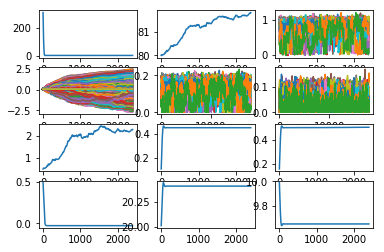

0.5859637783634186


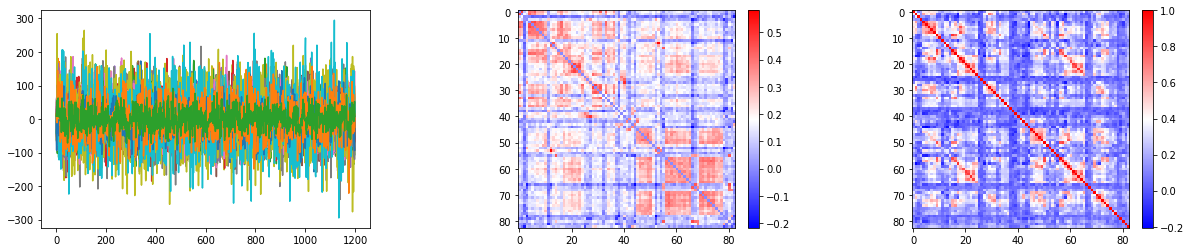

3 172332


<Figure size 432x288 with 0 Axes>

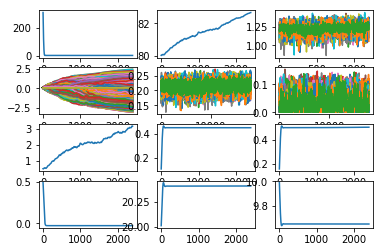

0.6669056686968184


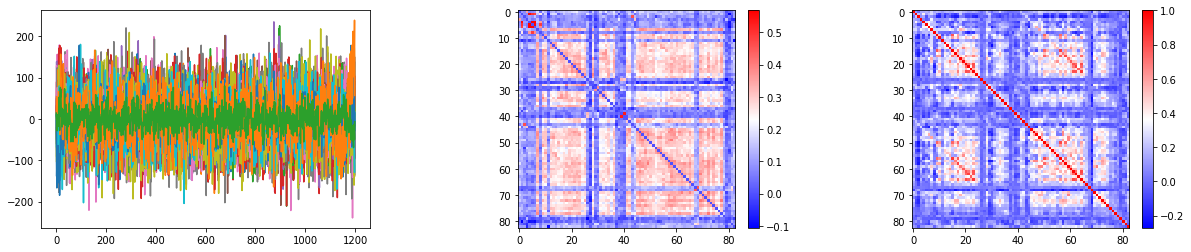

4 181131


<Figure size 432x288 with 0 Axes>

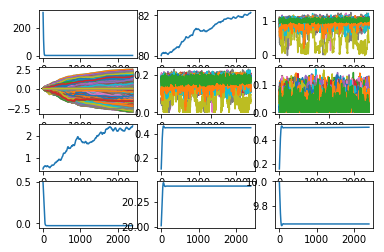

0.6107399182246168


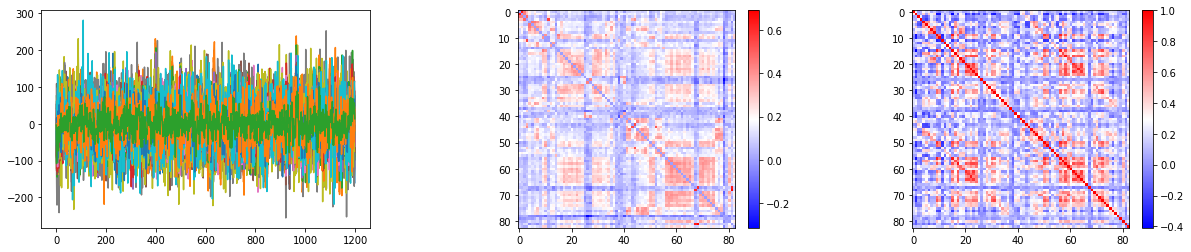

5 317332


<Figure size 432x288 with 0 Axes>

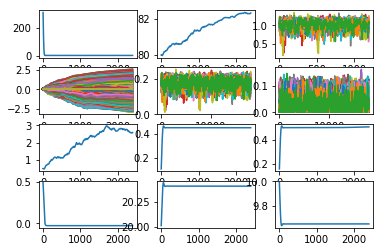

0.6750470574475421


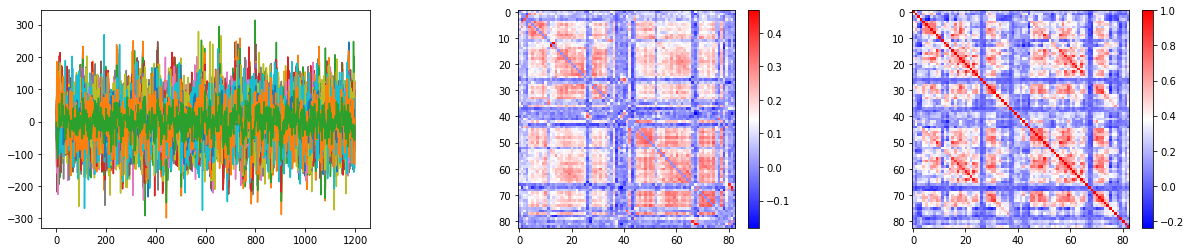

6 196750


<Figure size 432x288 with 0 Axes>

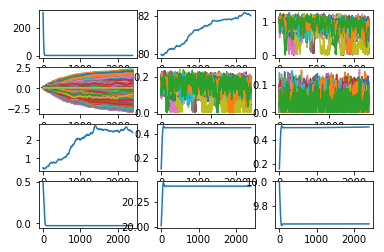

0.6826945444550373


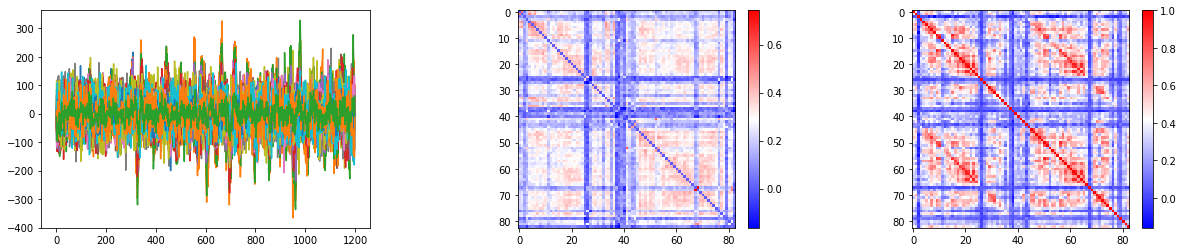

7 196144


<Figure size 432x288 with 0 Axes>

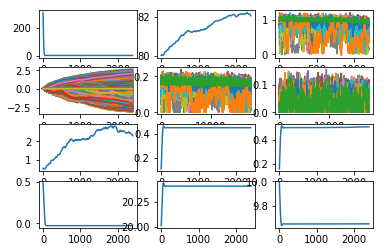

0.5641854778597757


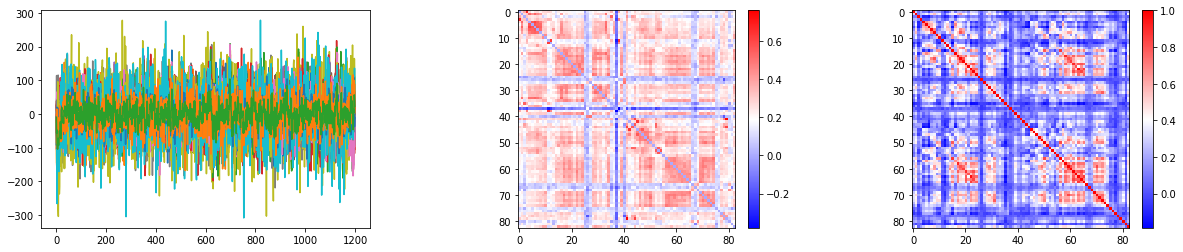

8 231928


<Figure size 432x288 with 0 Axes>

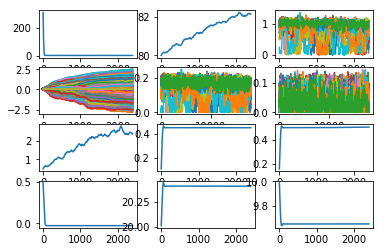

0.6092384615883524


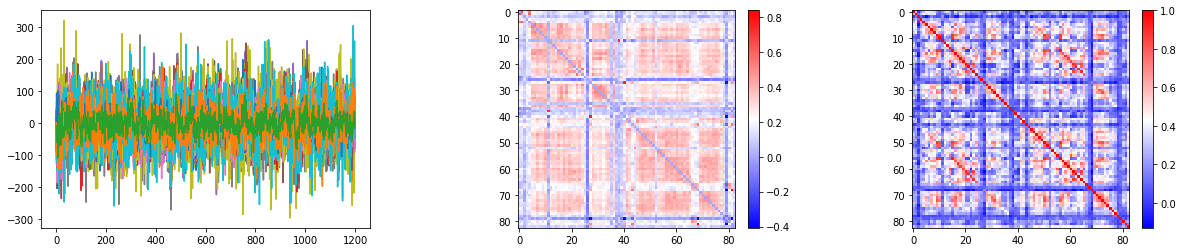

9 579867


<Figure size 432x288 with 0 Axes>

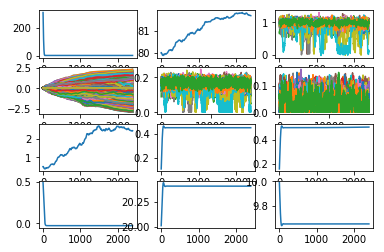

0.5237808554171189


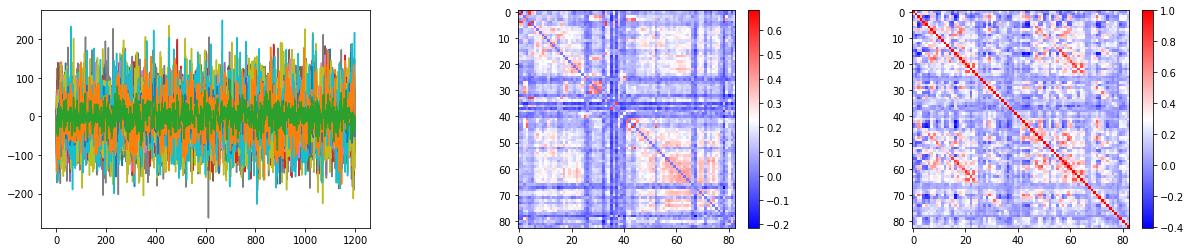

10 146432
11 148941


<Figure size 432x288 with 0 Axes>

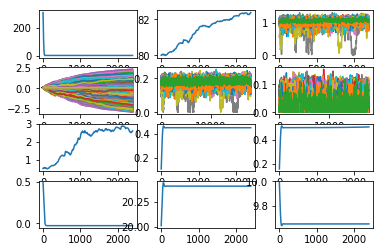

0.5880771998366494


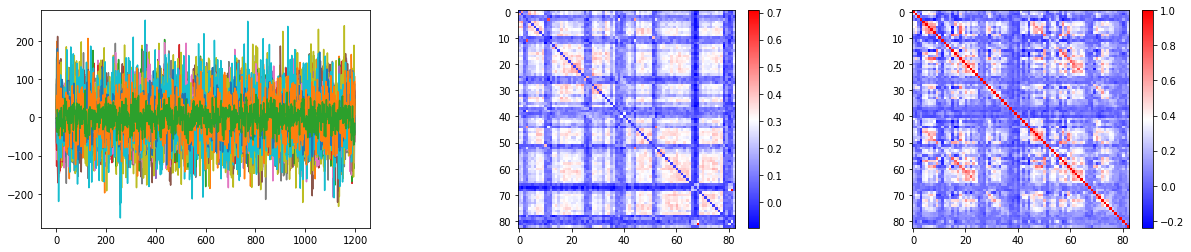

12 100307


<Figure size 432x288 with 0 Axes>

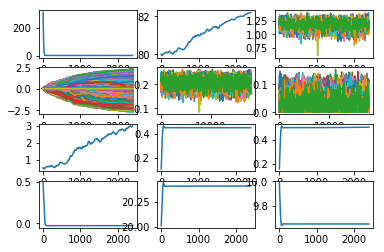

0.5738290607391809


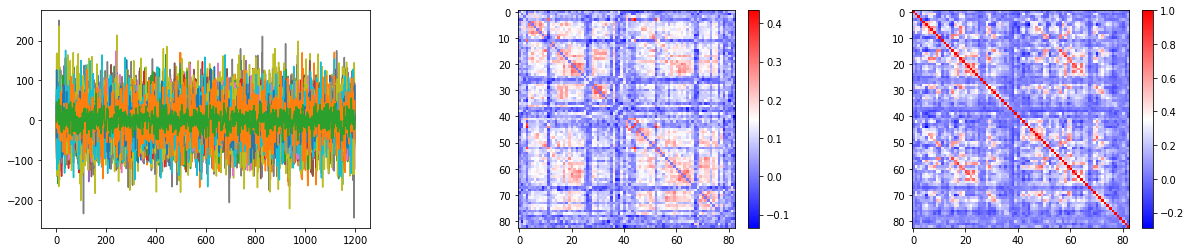

13 709551
14 155938
15 198451


<Figure size 432x288 with 0 Axes>

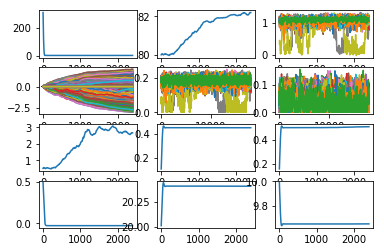

0.7062471600148301


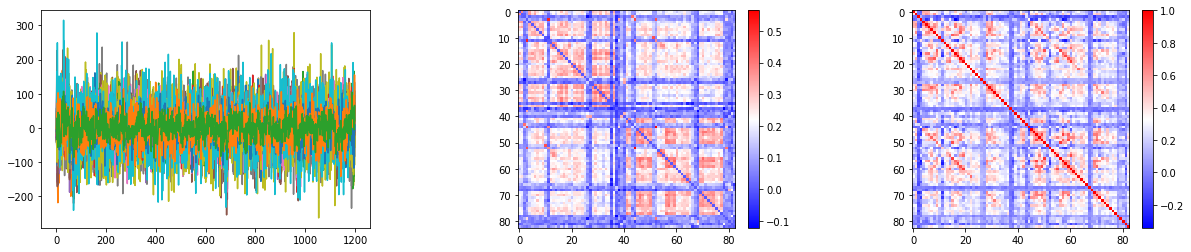

16 311320


<Figure size 432x288 with 0 Axes>

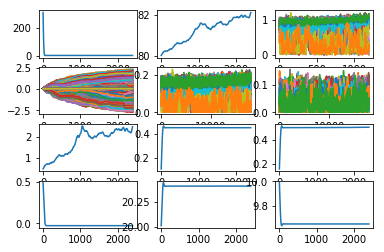

0.659674964339053


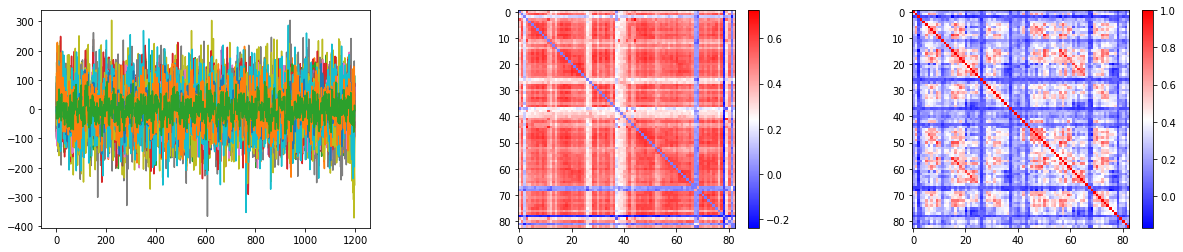

17 385450
18 173637


<Figure size 432x288 with 0 Axes>

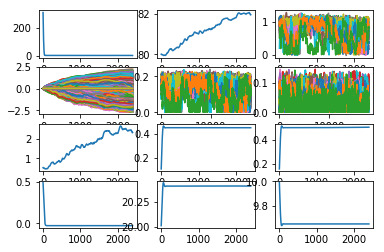

0.5428183883082079


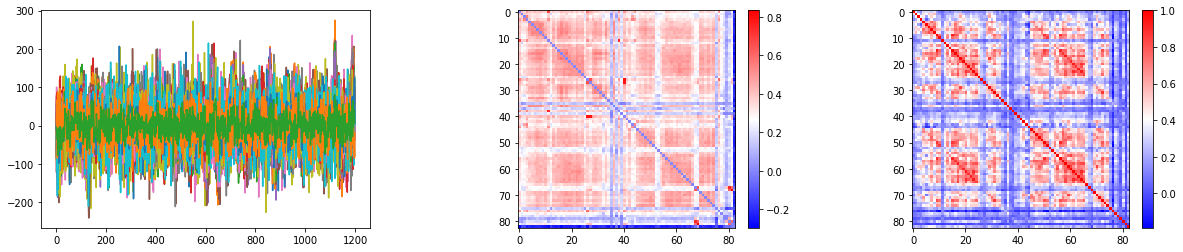

19 181636


<Figure size 432x288 with 0 Axes>

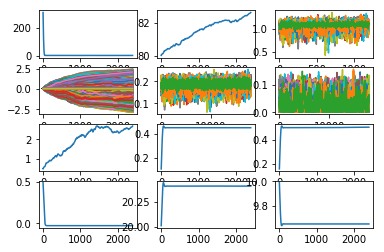

0.7088110123443313


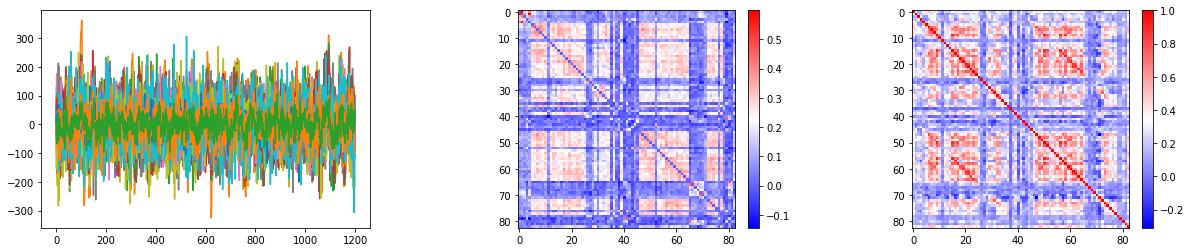

20 290136


<Figure size 432x288 with 0 Axes>

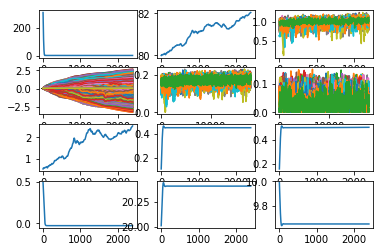

0.5116007917601484


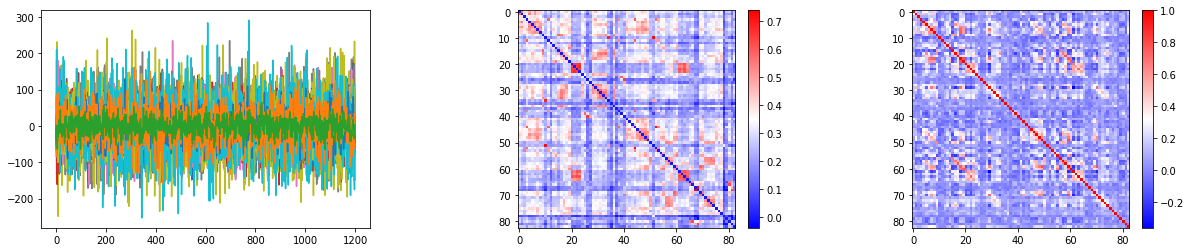

21 198653


<Figure size 432x288 with 0 Axes>

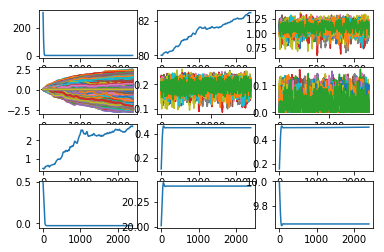

0.6827322983657513


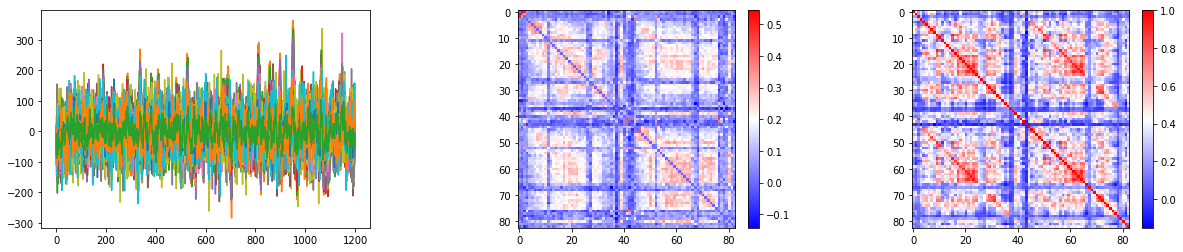

22 157336


<Figure size 432x288 with 0 Axes>

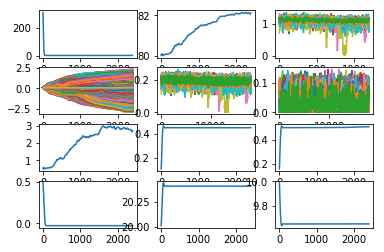

0.6301328750298686


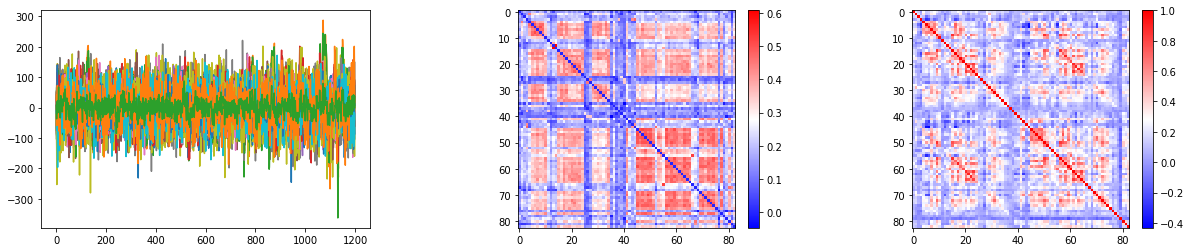

23 121921
24 145127
25 567961


<Figure size 432x288 with 0 Axes>

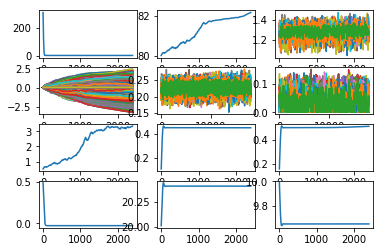

0.5660544929103057


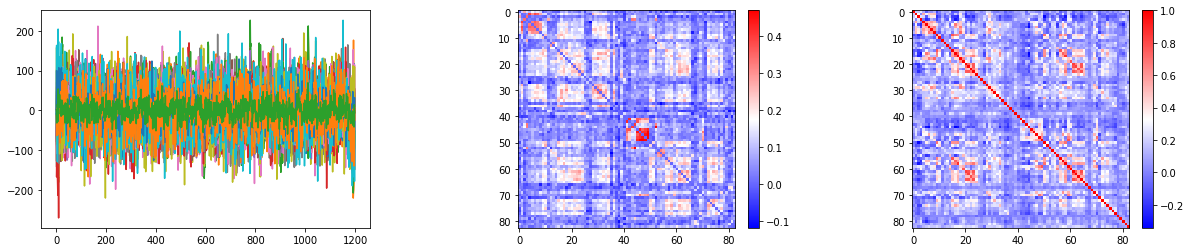

26 492754


<Figure size 432x288 with 0 Axes>

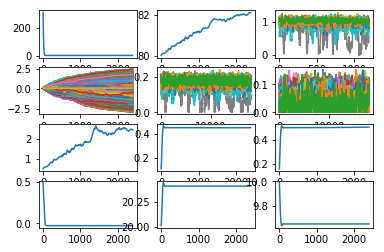

0.5084578962093246


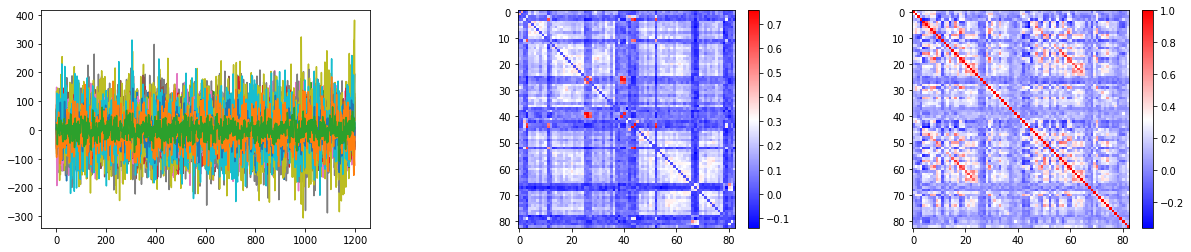

27 562446


<Figure size 432x288 with 0 Axes>

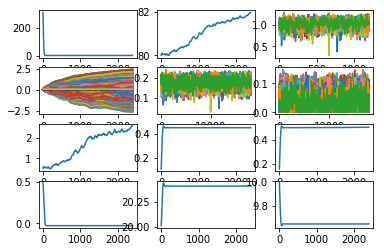

0.5580279307530606


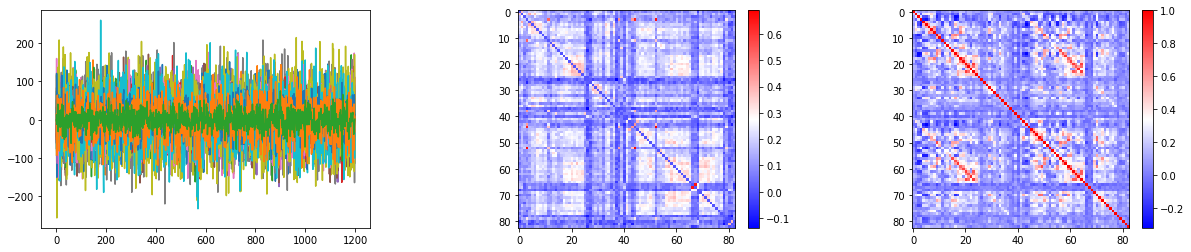

28 200210
29 151223
30 872158
31 579665


<Figure size 432x288 with 0 Axes>

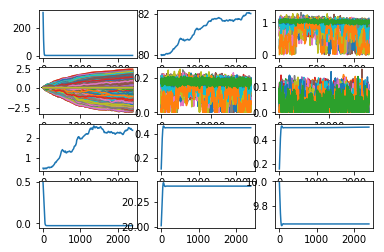

0.6385308805787966


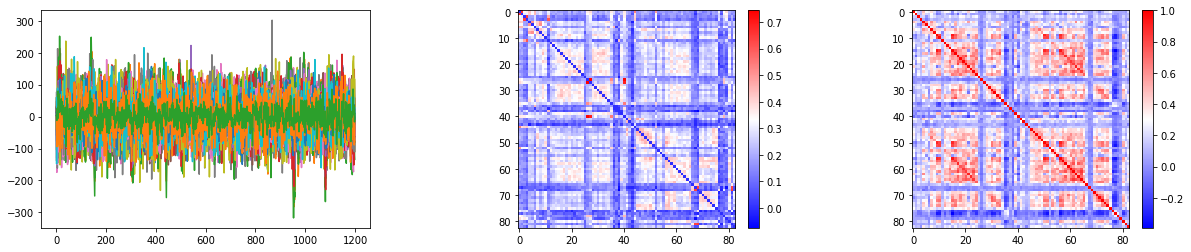

32 548250


<Figure size 432x288 with 0 Axes>

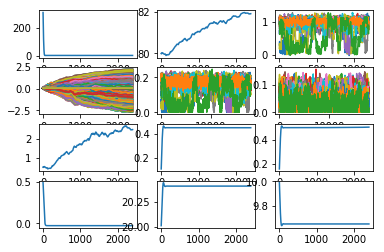

0.5098748914480353


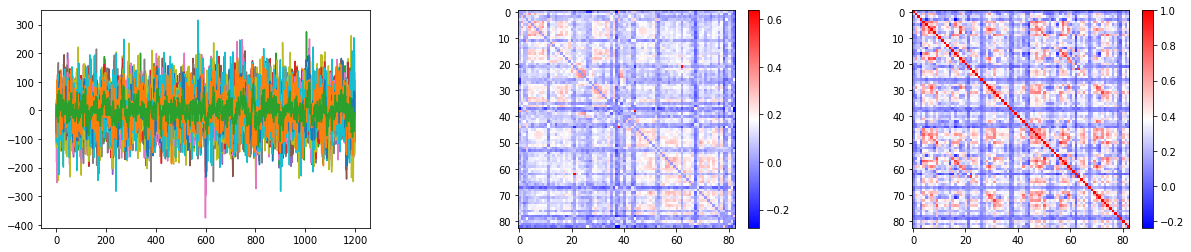

33 198350


<Figure size 432x288 with 0 Axes>

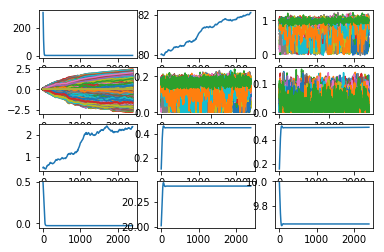

0.6292137167029404


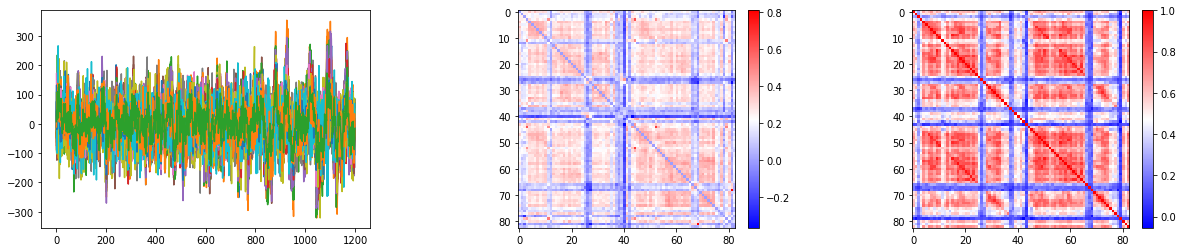

34 297655


<Figure size 432x288 with 0 Axes>

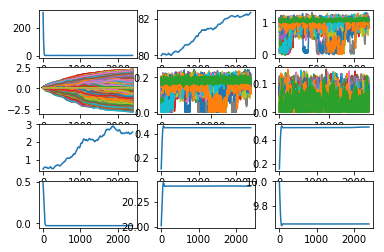

0.5444317225280734


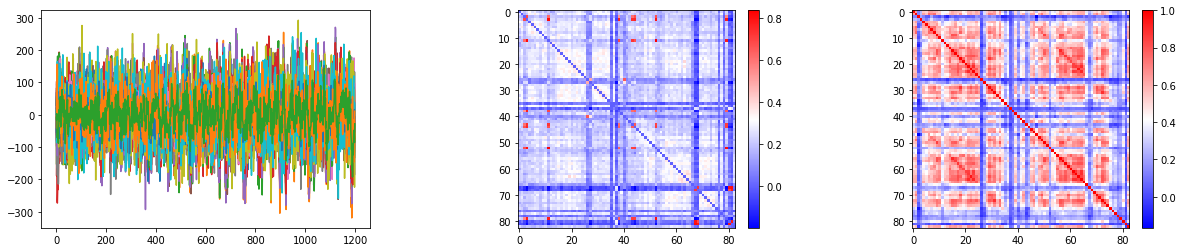

35 295146


<Figure size 432x288 with 0 Axes>

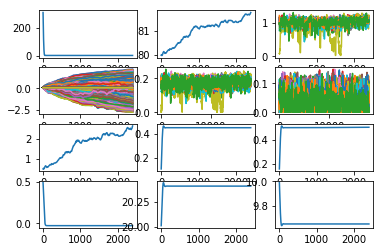

0.47605190884599907


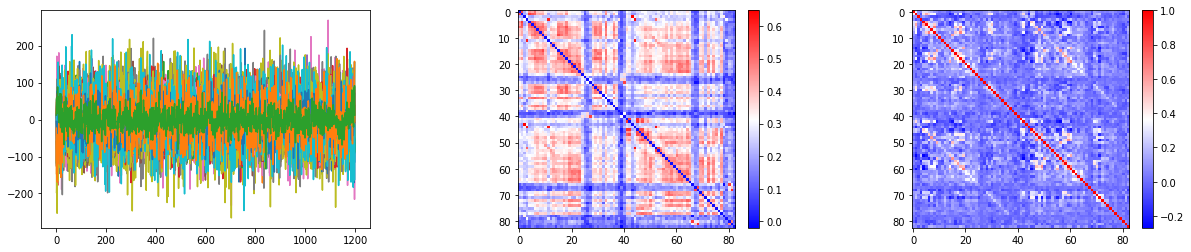

36 561444
37 183337


<Figure size 432x288 with 0 Axes>

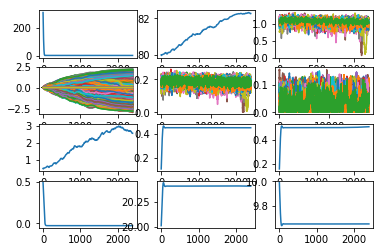

0.7688445535319962


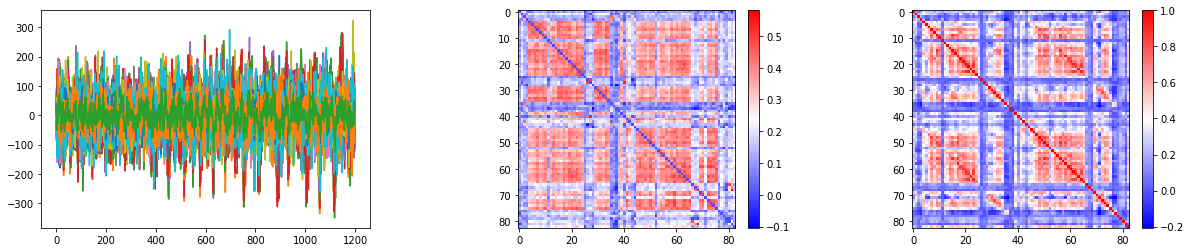

38 559053


<Figure size 432x288 with 0 Axes>

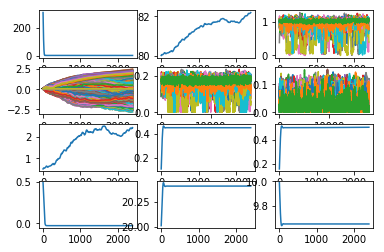

0.7047742591375018


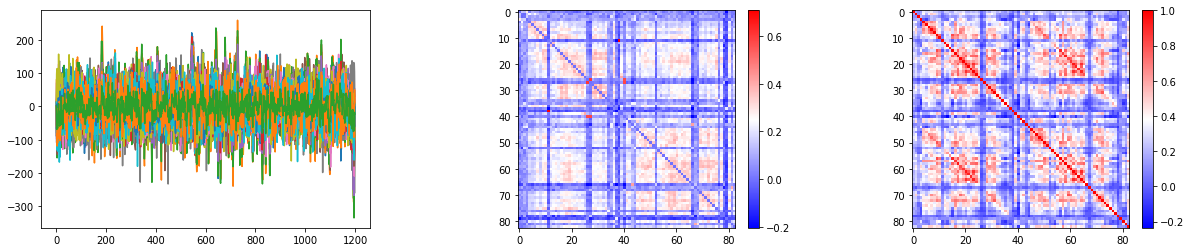

39 519950


<Figure size 432x288 with 0 Axes>

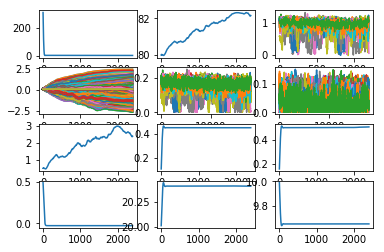

0.5671492761693788


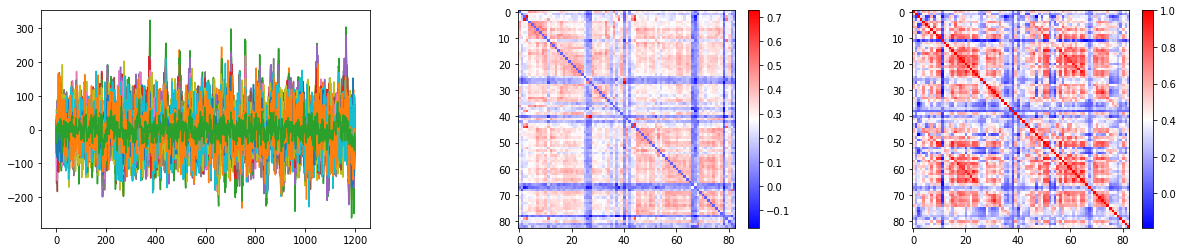

40 220721
41 197550


<Figure size 432x288 with 0 Axes>

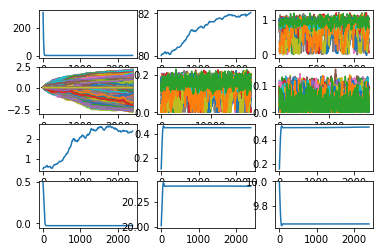

0.5275035568023221


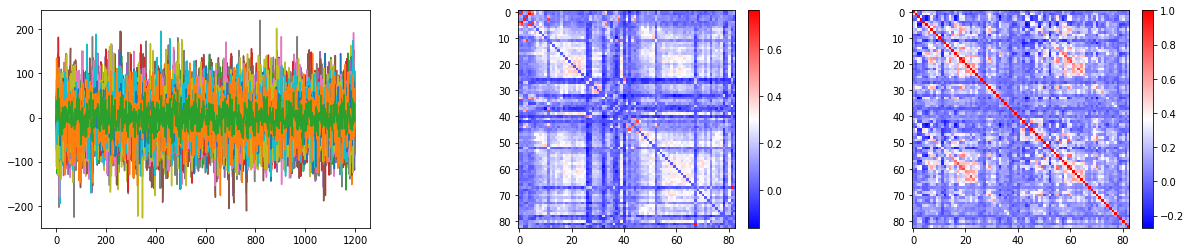

42 179952


<Figure size 432x288 with 0 Axes>

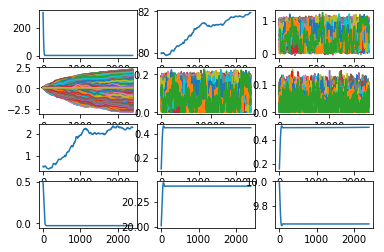

0.6215359950330931


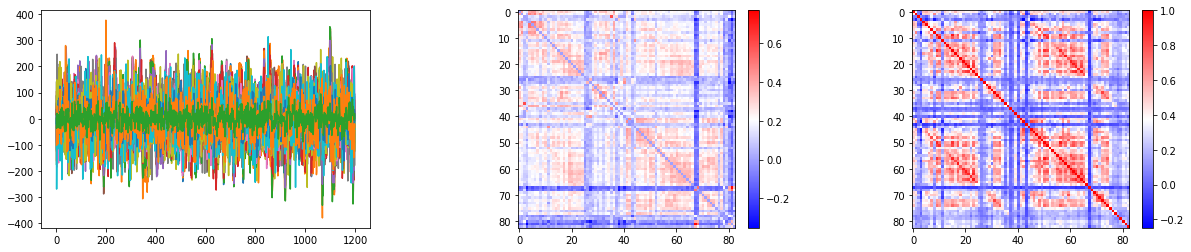

43 151526


<Figure size 432x288 with 0 Axes>

In [ ]:
SC_base_dir= '/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_tracks_conmats/data/results/hcp_wuminn/tractography/dipy/l2k8/'
TS_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
out_dir ='/brunhild/mcintosh_lab/jwang/ModelFitting/test/'
HCP_par_corr= {}
ROI_size = 83
#groups= ['CON_MCI']

subs=[sub for sub in os.listdir(SC_base_dir) if os.path.isdir(SC_base_dir+sub)]
#subs = subs[295:]
for i in range(len(subs)):
    sub =subs[i]
    print(i, sub)
    SC_file = SC_base_dir+ sub +'/dsi_sd4/sub-' +sub +'_roisc33dwispace/weights.txt'
    TS_file = TS_base_dir+sub+ '_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
#groups= ['CON_MCI']



    
    if os.path.isfile(SC_file) and os.path.isfile(TS_file):
        HCP_par_corr[sub] = []
        SC= np.loadtxt(SC_file)
        SC = SC -np.diag(np.diag(SC))
        TS_df=pd.read_pickle(TS_file)
        TS=TS_df.values
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        SC = (SC+SC.T)*0.5
        """SC1=SC[:48,:48].copy()
        SC2=SC[48:96,48:96].copy()
        SC3=SC[:48,48:96].copy()
        mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
        SC1[mask1]=0
        SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
        SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
        SC[:48,:48] = SC1
        SC[48:96,48:96] = SC2
        SC[:48,48:96] = 1*SC3
        SC[48:96,:48] = 1*SC3.T"""
        Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
        corr_fit = F.train(sub, Wo, TS)

In [ ]:
groups =['CON_MCI']

In [ ]:
para_corr={}
for grp in groups:
    print(grp)
    grp_dir = data_dir +grp + '/'
    subs = [sub for sub in os.listdir(grp_dir) if str.isdigit(sub)]
    for i in range(len(subs)):
        subID =subs[i]
            
        file_path= '/brunhild/mcintosh_lab/jwang/ModelFitting/' + data_set +'/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        print(i, subID)
        SC_file = grp_dir + subID + '/preprocess/connectivity/SC/SC.txt'
        TS_file = grp_dir + subID + '/preprocess/connectivity/FC/TS.txt'
        if os.path.isfile(SC_file) and os.path.isfile(TS_file):
            para_corr[data_set+subID]= []
            SC= np.loadtxt(SC_file)
            TS= np.loadtxt(TS_file)
            TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
            SC = (SC+SC.T)*0.5
            """SC1=SC[:batch_size//2,:batch_size//2].copy()
            SC2=SC[batch_size//2:batch_size,batch_size//2:batch_size].copy()
            SC3=SC[:batch_size//2,batch_size//2:batch_size].copy()
            mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
            SC1[mask1]=0
            SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
            SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
            SC[:batch_size//2,:batch_size//2] = SC1
            SC[batch_size//2:batch_size,batch_size//2:batch_size] = SC2
            SC[:batch_size//2,batch_size//2:batch_size] = 1*SC3
            SC[batch_size//2:batch_size,:batch_size//2] = 1*SC3.T"""
            Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
                #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
                
            corr_fit = F.train(subID, Wo, TS_dmean)
            """para_corr[data_set+subID].append(corr_fit)
            corr_sim =F.test(subID, Wo, TS_dmean)
            para_corr[data_set+subID].append(corr_sim)
            params = np.loadtxt(out_dir+subID+'paramsList.txt')
            Theta = list(params[-10:,:].mean(axis = 0))
            para_corr[data_set+subID].extend(Theta)"""
                

CON_MCI
0 4032


<Figure size 432x288 with 0 Axes>

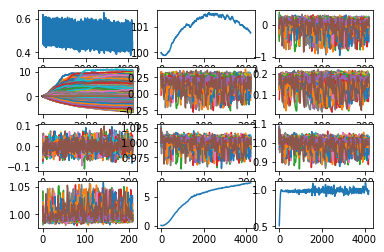

0.6647434155478447


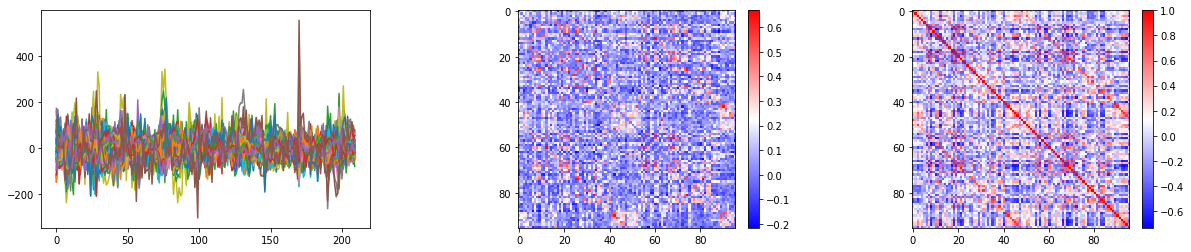

In [10]:
para_corr={}
for grp in groups:
    print(grp)
    grp_dir = data_dir +grp + '/'
    subs = [sub for sub in os.listdir(grp_dir) if str.isdigit(sub)]
    for i in range(len(subs)):
        subID =subs[i]
            
        file_path= '/brunhild/mcintosh_lab/jwang/ModelFitting/' + data_set +'/'
        if not os.path.exists(file_path):
            os.mkdir(file_path)
        print(i, subID)
        SC_file = grp_dir + subID + '/preprocess/connectivity/SC/SC.txt'
        TS_file = grp_dir + subID + '/preprocess/connectivity/FC/TS.txt'
        if os.path.isfile(SC_file) and os.path.isfile(TS_file):
            para_corr[data_set+subID]= []
            SC= np.loadtxt(SC_file)
            TS= np.loadtxt(TS_file)
            TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
            SC = (SC+SC.T)*0.5
            """SC1=SC[:batch_size//2,:batch_size//2].copy()
            SC2=SC[batch_size//2:batch_size,batch_size//2:batch_size].copy()
            SC3=SC[:batch_size//2,batch_size//2:batch_size].copy()
            mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
            SC1[mask1]=0
            SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
            SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
            SC[:batch_size//2,:batch_size//2] = SC1
            SC[batch_size//2:batch_size,batch_size//2:batch_size] = SC2
            SC[:batch_size//2,batch_size//2:batch_size] = 1*SC3
            SC[batch_size//2:batch_size,:batch_size//2] = 1*SC3.T"""
            Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
                #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
                
            corr_fit = F.train(subID, Wo, TS_dmean)
            """para_corr[data_set+subID].append(corr_fit)
            corr_sim =F.test(subID, Wo, TS_dmean)
            para_corr[data_set+subID].append(corr_sim)
            params = np.loadtxt(out_dir+subID+'paramsList.txt')
            Theta = list(params[-10:,:].mean(axis = 0))
            para_corr[data_set+subID].extend(Theta)"""
                

In [12]:
batch_size//2

48

In [10]:
f


In [13]:
f.param['sigma']

<tf.Tensor 'add_5:0' shape=() dtype=float32>

In [12]:
f.L

<tf.Tensor 'add:0' shape=(96, 96) dtype=float32>

In [29]:
graph_deco.variables_ls

[<tf.Variable 'Variable:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=() dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=() dtype=float32_ref>]